In [55]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime as dt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


In [152]:
df = pd.read_csv('../result/result_0403_0509.csv')
df['orderDate'] = pd.to_datetime(df['orderDate'],format='%Y%m%d')
df['click_time'] = df['subParam'].str.split('_').str.get(1)
df['subParam'] = df['subParam'].str.split('_').str.get(0)

1. 구매 범위가 너무 넓음. 아웃라이어를 초 VIP 구간으로 넣고, 나머지 평균을 구간화 하기
2. 유저 클릭 시간대 분포와 매출간의 상관성과 분포 보기
3. 유저 아이디 <> MMP 행동 매칭해서, 회귀분석
4. 재방문과 재구매와의 상관관계 보고, uplift 확인하기

In [154]:
df.columns

Index(['Unnamed: 0', 'orderDate', 'trackingCode', 'subId', 'subParam',
       'addtag', 'ctag', 'orderId', 'productId', 'productName', 'quantity',
       'gmv', 'commissionRate', 'commission', 'date', 'refund_quantity',
       'refund_gmv', 'refund_commission', 'total_gmv', 'total_commission',
       'total_quantity', 'click_time'],
      dtype='object')

In [155]:
df = df[(df['subParam'].notna()) & (df['subParam']!="0")]
df = df.query("subParam.notna()").groupby('subParam').agg({'total_gmv':'sum','total_commission':'sum','total_quantity':'sum'}).reset_index()

In [88]:
df = df[df['total_gmv']>0]

In [89]:
len(df)

25980

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


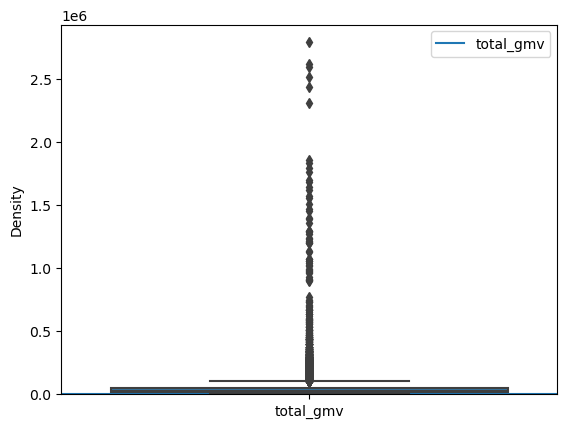

In [90]:
sns.kdeplot(df)
sns.boxplot(df)
plt.show()

In [156]:
import statsmodels
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler

In [157]:
df['zscore'] = ss.zscore(df['total_gmv'])


In [109]:
rs = RobustScaler()
df['scaler'] = rs.fit_transform(df['total_gmv'].values.reshape(-1,1))

In [110]:
df

,subParam,total_gmv,zscore,scaler
0,00027209-52db-4a23-9918-3163f8484c4a,21570.0,-0.285919,-0.142383
1,000518c4-c2c7-45e4-92e0-9cabb94c889b,11800.0,-0.403407,-0.412758
2,000b3874-e05c-4738-9a84-b4d33f90703f,8680.0,-0.440926,-0.499101
3,000c2bc8-d3d6-4f98-b73e-0369cd27641b,90790.0,0.546481,1.773212
4,000eac0e-11f4-45f5-95a4-2fe17e4d634e,65640.0,0.244042,1.077210
...,...,...,...,...
26899,fff35da5-cd77-4eef-a0f9-66f317b1818e,34500.0,-0.130430,0.215442
26900,fff389dd-e35f-4c5c-9979-105e15cf0a6e,8910.0,-0.438160,-0.492736
26901,fff79c69-957e-45a8-8100-10085e8322c2,4650.0,-0.489389,-0.610627
26902,fff90531-f4b6-4b14-a128-90fd2a74c4ca,14850.0,-0.366729,-0.328352


c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


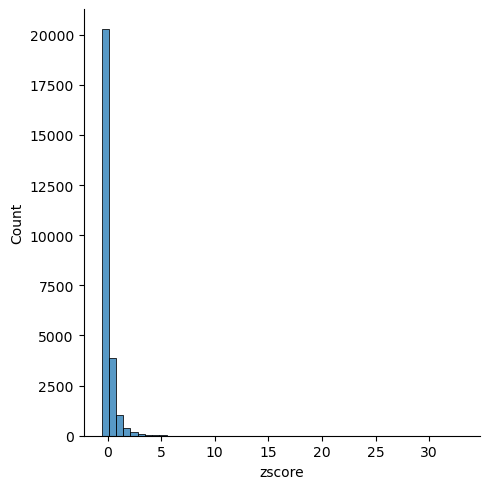

In [114]:
sns.displot(df['zscore'],bins=50)
plt.show()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


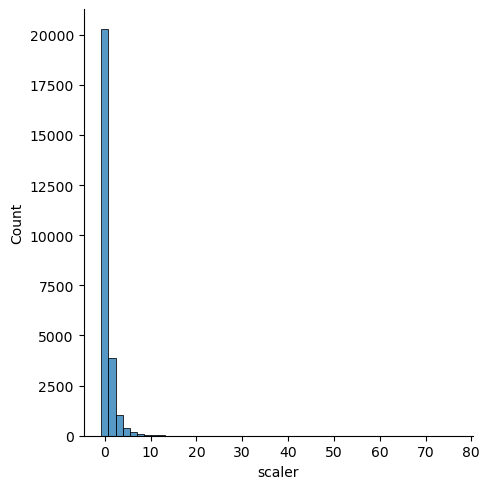

In [115]:
sns.displot(df['scaler'],bins=50)
plt.show()

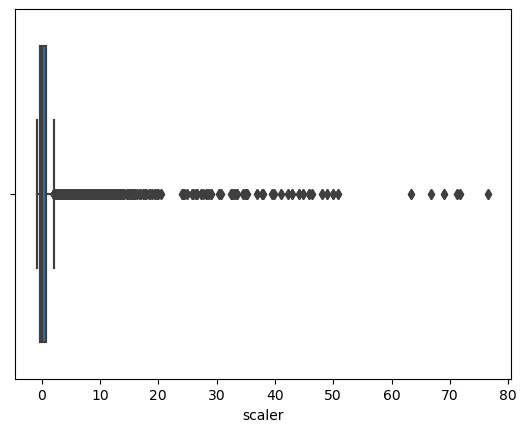

In [118]:
sns.boxplot(x=df['scaler'])
plt.show()

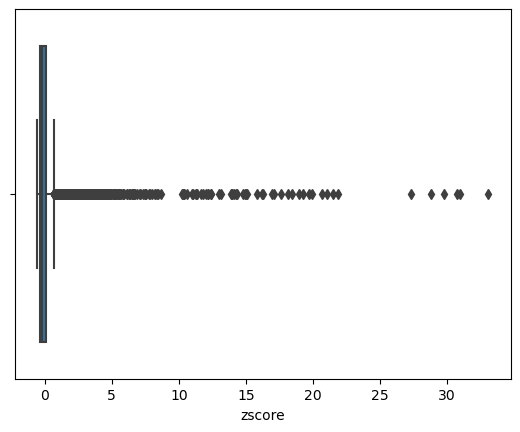

In [119]:
sns.boxplot(x=df['zscore'])
plt.show()

In [161]:
df['outlier'] = df['zscore'].abs() > 3

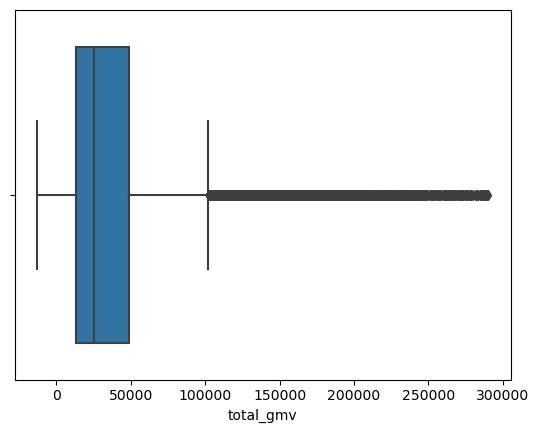

In [162]:
tt = df.query('outlier == False')
sns.boxplot(x=tt['total_gmv'])
plt.show()

In [163]:
tt.total_gmv.mean()

38504.42743576278

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


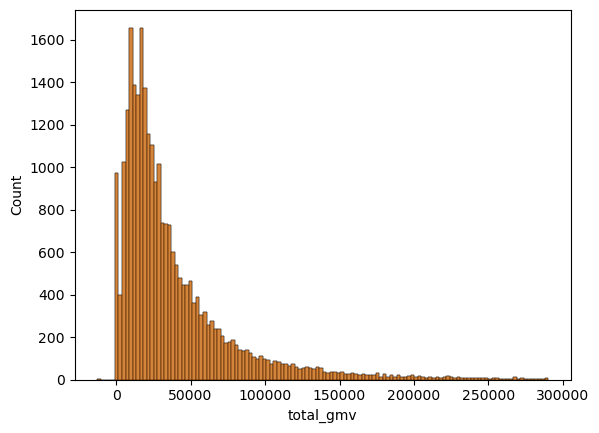

In [168]:
sns.histplot(tt.total_gmv)
plt.show()